# CH2. Data and Sampling Distributions

**데이터와 표본분포**

**2.1 임의표본추출(random sampling)과 표본편향(sample bias)**

**2.2 선택편향(selection bias)**

**2.3 통계학에서의 표본분포**

**2.4 부트스트랩**

**2.5 신뢰구간**

통계에서 표본분포라는 용어는 하나의 동일한 모집단에서 얻은 여러 샘플에 대한 표본 통계량으 분포를 나타낸다.

**용어정리**

> 표본통계량(sample statistic): 더 큰 모집단에서 추출된 표본 데이터들로 부터 얻은 측정 지표

> 데이터 분포(data distribution): 어떤 데이터 집합에서의 각 개별 값의 분포

> 표본분포(sampling distribution): 여러 표본들에서, 혹은 재표본들로 부터 얻은 표본통계량의 도수분포

> 중심극한정리(contral limit theorem): 표본크기가 커질수록 표본분포가 정규분포를 따르는 경향

> 표준오차(standard eroor): 여러표본들로부터 얻은 표본통계량의 변량(개별 데이터 값들의 변량을 뜻하는 표준편차와 혼동하지 말것)

In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

## 데이터 import

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

# 데이터 표본의 개수에 따른 표본분포
---
2.2 Data and Sampling Distributions


## 랜덤 데이터 생성후 분포보기

In [4]:
# random data 생성후 distribution 보기
np.random.seed(seed = 1)

# -3부터 3까지의 300개의 랜덤 데이터
x = np.linspace(-3, 3, 300)

In [5]:
# jupyternotebook에서 스압이 발생하므로 shape만 보겠습니다.

x.shape

(300,)

In [6]:
# 정규분포를 따르는 랜덤한 샘플을 1000개 뽑습니다.
# option size는 Defining number of random variates (default is 1)
xsample = stats.norm.rvs(size = 1000, random_state = 1)

In [7]:
whatistthat = stats.norm.rvs(size = 2)
whatistthat

array([ 1.62434536, -0.61175641])

In [8]:
xsample.shape

(1000,)

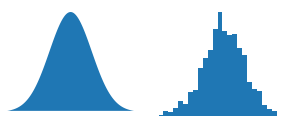

In [9]:
# 그래프를 그릴 준비. 두 그래프를, 각 열로, 한 행에 그릴 것임다.
fig, axes = plt.subplots(ncols = 2, figsize = (5, 2))

# 왼쪽 칸, 
# x와 x의 확률밀도함수pdf(x)의 값을 y값으로 하는 그림에 x는 -3부터 3까지 그린다.
ax = axes[0]
ax.fill(x, stats.norm.pdf(x))
ax.set_axis_off()
ax.set_xlim(-3, 3)

# 오른쪽 칸,
# 정규분포를 따르는 xsample의 값들을 bins = 30 즉 30개씩 나눈 histogram을 그리며, x는 -3부터 3까지 그린다.
ax = axes[1]
ax.hist(xsample, bins = 30)
ax.set_axis_off()
ax.set_xlim(-3, 3)
ax.set_position

plt.show()

### 정리 및 원본 코드

이로 알 수 있는 것은 값들의 개수가 충분히 크면 정규분포를 따르게 된다는 그런 말.

In [10]:
# original whole code

# np.random.seed(seed=1)
# x = np.linspace(-3, 3, 300)
# xsample = stats.norm.rvs(size=1000)

# fig, axes = plt.subplots(ncols=2, figsize=(5, 1.5))

# ax = axes[0]
# ax.fill(x, stats.norm.pdf(x))
# ax.set_axis_off()
# ax.set_xlim(-3, 3)

# ax = axes[1]
# ax.hist(xsample, bins=30)
# ax.set_axis_off()
# ax.set_xlim(-3, 3)
# ax.set_position
# # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

# plt.show()

# 통계에서의 표본분포
---
**2.3 Sampling Distribution of a Statistic**

### LOANS_INCOME_CSV: 랜딩클럽에 대출을 신청한 사람들의 연간 소득 정보

이를 이용하여 샘플의 개수를 n개씩 뽑았을 때의 평균의 분포를 보도록 해본다.

In [11]:
# data reading
# option 'squeeze' : squeeze : bool, default False
# If the parsed data only contains one column then return a Series.
# 데이터 프레임이 아니라 시리즈로 바로 불러오는 용도인 것으로 보인다.

loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze = True)

/var/folders/qw/j72d9nwn5dq0vxtqtw2bbtnh0000gp/T/ipykernel_1713/86367278.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze = True)


없애지 말아주세요... 

In [12]:
loans_income

0         67000
1         52000
2        100000
3         78762
4         37041
          ...  
49995     40000
49996     54000
49997     50000
49998     82000
49999     70000
Name: x, Length: 50000, dtype: int64

### numbers and samples mean numbers

샘플을 뽑는 개수에 따라 몇개 데이터 셋을 만들어본다.

In [13]:
# 1000 개를 바로 뽑았을 떄
sample_data = pd.DataFrame({
    'income' : loans_income.sample(1000),
    'type' : 'Data',})

# 5개 뽑았을 때의 평균을 1000번 냈을 때
sample_mean_05 = pd.DataFrame({
    'income' : [loans_income.sample(5).mean() for _ in range(1000)],
    'type' : 'Mean of n = 5',})

# 20개 뽑았을 떄의 평균을 1000번 냈을 때
sample_mean_20 = pd.DataFrame({
    'income' : [loans_income.sample(20).mean() for _ in range(1000)],
    'type' : 'Mean of n = 20',})

In [14]:
# 결과를 한 데이터프레임으로 합쳐줍니다.

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
print(results.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 32525 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   income  3000 non-null   float64
 1   type    3000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 70.3+ KB
None


In [15]:
print(results.head())

# 당연하겠지만 책에서 하는 값과는 다르게 나옵니다. (물론 실행할 때마다 다르게)

         income  type
32525  140000.0  Data
38271  130405.0  Data
8078    70000.0  Data
33104  110000.0  Data
29128   95000.0  Data


### graph 

원본 데이터에서 뽑은 데이터와, 데이터를 여러번 뽑으며 낸 평균들의 모습으로든 소득 구간에 따른 대출신청자수를 본다.

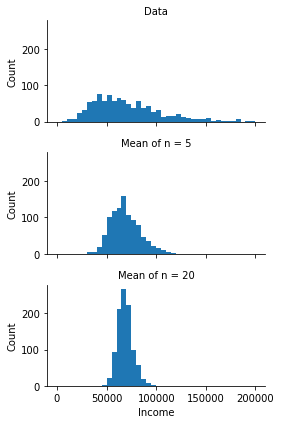

In [16]:
# results 데이터로, columns은 'type' 이 들어가며
# 세로로 3개로 그릴 것이기 때문에 열 개수 하나의 그리드 만든다
g = sns.FacetGrid(results, col = 'type', col_wrap = 1, 
                  height = 2, aspect = 2)

# 그리드 안에 hist를 그려 넣는데
# 원래 데이터의 값 스케일에 맞는 x range 를 정해주고,
# 40개씩 잘라서 넣는다. concat 후 정렬되어있지 않기 때문에 
# 각각 25개의 막대가 그려지고 다음 데이터는 다음 그림으로 넘어가게 될 것이다.
g.map(plt.hist, 'income', range = [0, 200000], bins = 40)

# 각label. col_name에는 type 즉 우리가 이름지어준 것이 들어갈 것이다.
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

### 정리 및 궁금한 점

> 평균과 같은 표본통계량의 분포는 데이터 자체의 분포보다 규칙적이고 종 모양일 가능성이 높다. 통계의 기반이 되는 표본이 클수록, 그럴 가능성이 높은 것이 사실이다. 또한 표본이 클수록 표본통계량의 분포가 좁아진다.

> 이 결과로, 개별 데이터로의 히스토그램은 넓게 분산되어있고, 한쪽으로 기울어져있다. 그러나 5와 20개씩 뽑아평균을 내어 1000개의 데이터 포인트를 만든 것은 갈수록 좁고 종모양이 된다. 

그렇다면 궁금해진 것인데, 평균의 평균을 낸 것들은 원래의 평균과 얼마나 차이가 나지?


### how much are their mean...?


In [17]:
# 레코드를 구분지어주는 라벨인 type 값 확인

results['type'].unique()

array(['Data', 'Mean of n = 5', 'Mean of n = 20'], dtype=object)

In [18]:
# 각각의 평균은 어땠을까?

for i in ['Data', 'Mean of n = 5', 'Mean of n = 20']:
    print('type' , i)
    print(results[results['type'] == i]['income'].mean())

type Data
69456.693
type Mean of n = 5
68633.5564
type Mean of n = 20
68788.7336


많이 차이안난다. 그렇다면 원래의 데이터에서의 mean은 얼마일까?

In [19]:
loans_income.mean()

68760.51844

랜덤하게 추출한 표본들의 샘플들의 평균들로 평균을 낸 것이 그저 무작위로 추출한 데이터 자체의 평균보다 모집단 loans_income의 평균에 더 가깝게 나타나는 것으로 나왔다.

간단하게만 생각해도, 그만큼 여러 샘플들(더 많은 표본들)을 반영하는 것과 마찬가지이기 때문이라는 생각도 든다.

### 원본 코드

In [20]:
# origin whole code

# loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze=True)

# sample_data = pd.DataFrame({
#     'income': loans_income.sample(1000),
#     'type': 'Data',
# })

# sample_mean_05 = pd.DataFrame({
#     'income': [loans_income.sample(5).mean() for _ in range(1000)],
#     'type': 'Mean of 5',
# })

# sample_mean_20 = pd.DataFrame({
#     'income': [loans_income.sample(20).mean() for _ in range(1000)],
#     'type': 'Mean of 20',
# })

# results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
# print(results.head())

In [21]:
# origin whole code

# g = sns.FacetGrid(results, col='type', col_wrap=1, 
#                   height=2, aspect=2)
# g.map(plt.hist, 'income', range=[0, 200000], bins=40)
# g.set_axis_labels('Income', 'Count')
# g.set_titles('{col_name}')

# plt.tight_layout()
# plt.show()

# 부트스트랩 !
---
**2.4 The Bootstrap**

> 부트스트랩: 현재 있는 표본에서 추가적으로 표본을 복원추출하고 각 표본에 대한 통계량과 모델을 다시 계산하는 절차

위에서 진행했던 값들을 토대로 부트스트랩 과정을 통해서 샘플링 과정에서 생길 수 있는 편향에 대해 알아보고자 한다.

표본자체를 무식하게 반복 복제한다는 것이아니라, 각각의 표본을 뽑은 후 각 관측치를 다시 원래 자리에 돌려놓는다. (복원추출)

뽑을 때마다 각 원소가 뽑힐 확률은 그대로 유지하면서 무한한 크기의 모집단을 만들어낼 수 있다.

크기 n의 샘플의 평균을 구하는 부트스트랩 재표본추출 알고리즘은 이렇다.

1. 샘플값을 하나 뽑아서 기록한 후 다시 원래대로 돌려놓는다.
2. n번 반복한다.
3. 재표본추출된 값의 평균을 기록한다.
4. 1~3 과정을 R번 반복한다.
5. R개의 결과를 사용하여 표준편차(표본평균의 표준오차)를 계산한다. 리스토그램이나 박스플롯을 그리고, 신뢰구간을 찾는다.

반복횟수를 크게 할 수록 표준오차나 신뢰구간에 대한 추정이 더 정확해진다. 


**용어정리**

> bootstrap sample: 관측 데이터 집합으로부터 얻은 복원추출 표본

> resampling(재표본추출, 재표집, 리샘플링): 관측 데이터로부터 반복해서 표본추출하는 과정. 부트스트랩과 순열(셔플링)과정을 포함한다.

### bootstrap으로 편향과 표준오차 구하기

In [22]:
"""
resample 의 n_samples 옵션은 
n_samples : int, default=None
    Number of samples to generate. If left to None this is
    automatically set to the first dimension of the arrays.
    If replace is False it should not be larger than the length of
    arrays.
"""

results1 = []
for n_repeat in range(1000):
    sample = resample(loans_income)    # 원데이터(loans_income)에서 리샘플함
    results1.append(sample.median())   # 해당 샘플의 중앙값을 결과리스트에 더함. 이 과정을 천번.

results1 = pd.Series(results1)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results1.mean() - loans_income.median()}')
print(f'std. error: {results1.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -82.09799999999814
std. error: 228.73933106830927


### 궁금하니 아래에서 두어번 더 실행해보도록 한다.

In [23]:
results2 = []
for n_repeat in range(1000):
    sample = resample(loans_income)
    results2.append(sample.median())

results2 = pd.Series(results2)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results2.mean() - loans_income.median()}')
print(f'std. error: {results2.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -84.36899999999878
std. error: 237.3956877273712


In [24]:
results3 = []
for n_repeat in range(1000):
    sample = resample(loans_income)
    results3.append(sample.median())

results3 = pd.Series(results3)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results3.mean() - loans_income.median()}')
print(f'std. error: {results3.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -87.46349999999802
std. error: 227.5191054859154




여기쯤에서 확인해보는 원래 데이터의 통계량을 살펴본다.

In [25]:
loans_income.describe()

count     50000.00000
mean      68760.51844
std       32872.03537
min        4000.00000
25%       45000.00000
50%       62000.00000
75%       85000.00000
max      199000.00000
Name: x, dtype: float64

### 정리 및 궁금한 점

그냥 궁금한건데, 그럼 저 결과들의 평균은 어떻고, 원 데이터의 스케일에 비해 편향은 얼마정도 되는 것일까? 

In [26]:
rs = [results1, results2, results3]

for r in rs:
    print(r.mean())

61917.902
61915.631
61912.5365


오!!! 평균이 중앙값과 가깝게 나타났다. 

In [27]:
bias3 = results3.mean() - loans_income.median()

abs(bias3) / (loans_income.median()) * 100

0.14107016129031938

# 신뢰구간
---
2.5 Confidence Intervals

## 90% 신뢰구간 시각화

대출 신청자들의 연간 소득정보를 90% 신뢰구간으로 그려본다.

68760.51844
55734.1


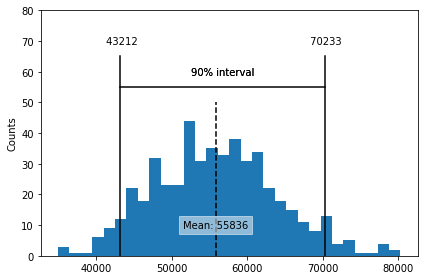

In [33]:
# 연간 소득 정보의 평균
print(loans_income.mean())

np.random.seed(seed = 3)

# 20개의 소득정보의 샘플을 만든다.
sample20 = resample(loans_income, n_samples = 20, replace = False)
print(sample20.mean())

# 샘플의 R = 500 의 부트스트랩
res = []
for nrepeat in range(500):
    sample = resample(sample20)
    res.append(sample.mean())
res = pd.Series(res)

# 신뢰구간 시각화
confidence_interval = list(res.quantile([0.05, 0.95]))
ax = res.plot.hist(bins = 30, figsize = (6,4))
ax.plot(confidence_interval, [55, 55], color = 'black')

for x in confidence_interval:
    ax.plot([x, x], [0,65], color = 'black')
    ax.text(x, 70, f'{x: .0f}',
           horizontalalignment = 'center', 
           verticalalignment = 'center')
    ax.text(sum(confidence_interval)/2, 60,
           '90% interval',
           horizontalalignment = 'center',
           verticalalignment = 'center')

meanIncome = res.mean()
ax.plot([meanIncome, meanIncome], [0, 50], 
        color = 'black', linestyle = '--')
ax.text(meanIncome, 10, f'Mean: {meanIncome:.0f}',
       bbox = dict(facecolor = 'white', edgecolor = 'white', alpha = 0.5),
       horizontalalignment = 'center', verticalalignment = 'center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [ ]:
# original code

# print(loans_income.mean())
# np.random.seed(seed=3)  
# # create a sample of 20 loan income data
# sample20 = resample(loans_income, n_samples=20, replace=False)
# print(sample20.mean())
# results = []
# for nrepeat in range(500):
#     sample = resample(sample20)
#     results.append(sample.mean())
# results = pd.Series(results)

# confidence_interval = list(results.quantile([0.05, 0.95]))
# ax = results.plot.hist(bins=30, figsize=(4, 3))
# ax.plot(confidence_interval, [55, 55], color='black')
# for x in confidence_interval:
#     ax.plot([x, x], [0, 65], color='black')
#     ax.text(x, 70, f'{x:.0f}', 
#             horizontalalignment='center', verticalalignment='center')
# ax.text(sum(confidence_interval) / 2, 60, '90% interval',
#         horizontalalignment='center', verticalalignment='center')

# meanIncome = results.mean()
# ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
# ax.text(meanIncome, 10, f'Mean: {meanIncome:.0f}',
#         bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
#         horizontalalignment='center', verticalalignment='center')
# ax.set_ylim(0, 80)
# ax.set_ylabel('Counts')

# plt.tight_layout()
# plt.show()

배울때 원래 예쁘게 시각화하는데 코드가 거의 쓰인다는 말을 체감하는 부분이다...

## 90%, 95% 신뢰구간 시각화

68760.51844
55734.1


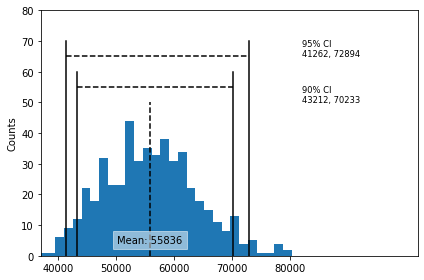

In [35]:
# 연간 소득 정보의 평균
print(loans_income.mean())

np.random.seed(seed = 3)

# 20개의 소득정보의 샘플을 만든다.
sample20 = resample(loans_income, n_samples = 20, replace = False)
print(sample20.mean())

# 샘플의 R = 500 의 부트스트랩
res = []
for nrepeat in range(500):
    sample = resample(sample20)
    res.append(sample.mean())
res = pd.Series(res)

# 신뢰구간 구하고 시각화
# 90% 신뢰구간
confidence_interval = list(res.quantile([0.05, 0.95]))
ax = res.plot.hist(bins = 30, figsize = (6,4), color = 'C1')
ax.plot(confidence_interval, [55, 55], color = 'black', linestyle = '--')

for x in confidence_interval:
    ax.plot([x, x], [0,60], color = 'black')
ax.text(82000, 50, 
        f'90% CI\n{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}',
        fontsize = 'small')

# 95% 신뢰구간
confidence_interval = list(res.quantile([0.025, 0.975]))
ax = res.plot.hist(bins = 30, figsize = (6,4))
ax.plot(confidence_interval, [65, 65], color = 'black', linestyle = '--')

for x in confidence_interval:
    ax.plot([x, x], [0,70], color = 'black')
ax.text(82000, 65, 
        f'95% CI\n{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}',
        fontsize = 'small')

meanIncome = res.mean()
ax.plot([meanIncome, meanIncome], [0, 50], 
        color = 'black', linestyle = '--')
ax.text(meanIncome, 5, f'Mean: {meanIncome:.0f}',
       bbox = dict(facecolor = 'white', edgecolor = 'white', alpha = 0.5),
       horizontalalignment = 'center', verticalalignment = 'center')
ax.set_ylim(0, 80)
ax.set_xlim(37000, 102000)
ax.set_xticks([40000, 50000, 60000, 70000, 80000])
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [ ]:
# original code

# np.random.seed(seed=3)
# # create a sample of 20 loan income data
# sample20 = resample(loans_income, n_samples=20, replace=False)

# results = []
# for nrepeat in range(500):
#     sample = resample(sample20)
#     results.append(sample.mean())
# results = pd.Series(results)

# confidence_interval = list(results.quantile([0.05, 0.95]))
# ax = results.plot.hist(bins=30, figsize=(4, 3), color='C1')
# ax.plot(confidence_interval, [55, 55], color='black', linestyle='--')
# for x in confidence_interval:
#     ax.plot([x, x], [0, 60], color='black')
# ax.text(82000, 50, 
#         f'90% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
#        fontsize='small')

# confidence_interval = list(results.quantile([0.025, 0.975]))
# ax = results.plot.hist(bins=30, figsize=(4, 3))
# ax.plot(confidence_interval, [65, 65], color='black', linestyle='--')
# for x in confidence_interval:
#     ax.plot([x, x], [0, 70], color='black')
# ax.text(82000, 65, 
#         f'95% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
#        fontsize='small')
# # ax.text(sum(confidence_interval) / 2, 264, '95 % interval',
# #         horizontalalignment='center', verticalalignment='center')

# meanIncome = results.mean()
# ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
# ax.text(meanIncome, 5, f'Mean: {meanIncome:.0f}',
#         bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
#         horizontalalignment='center', verticalalignment='center')
# ax.set_ylim(0, 80)
# ax.set_xlim(37000, 102000)
# ax.set_xticks([40000, 50000, 60000, 70000, 80000])
# ax.set_ylabel('Counts')

# # plt.tight_layout()
# # plt.show()